In [1]:
import numpy as np
from ase.io import read
from ase import Atoms
from ase.spacegroup.symmetrize import FixSymmetry
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from pandas import DataFrame
from phonopy.units import THzToCm
from seekpath import get_explicit_k_path
import phonopy
from matplotlib import pyplot as plt
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS

import mplpub
mplpub.setup(template='acs')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

-2.047060276607674
-2.0410524606901164
-2.0444214801490057
-2.0386299758160655


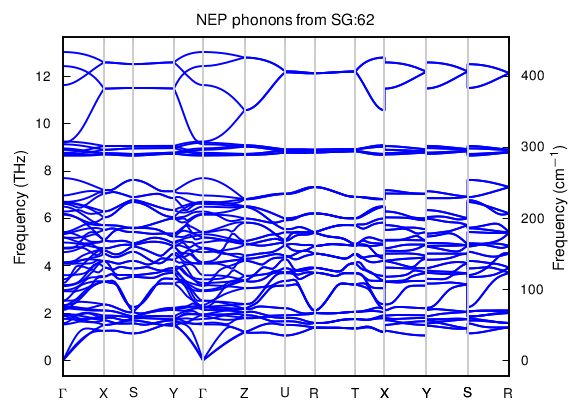

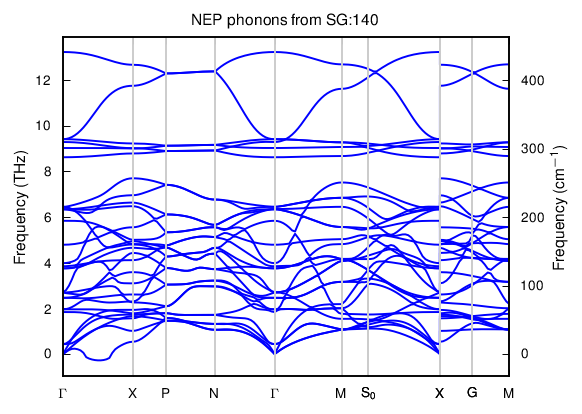

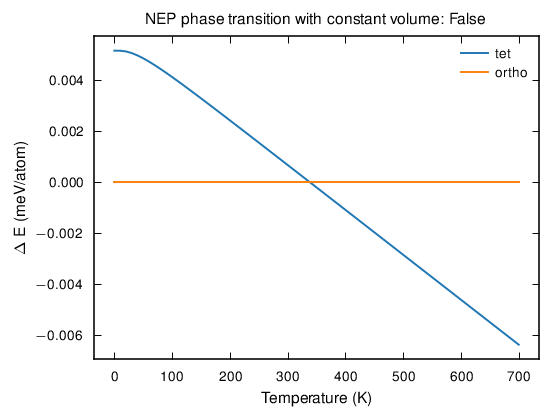

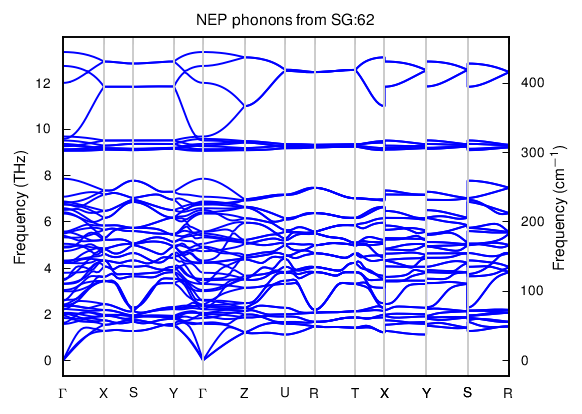

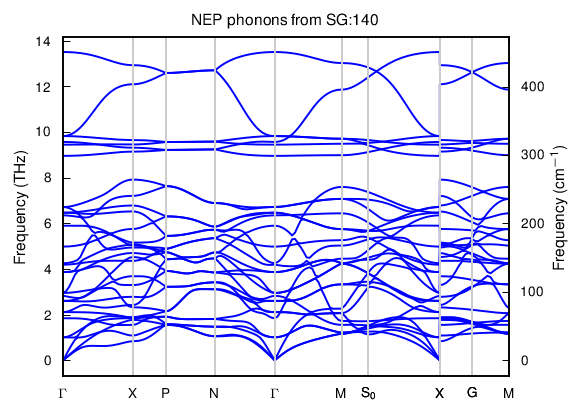

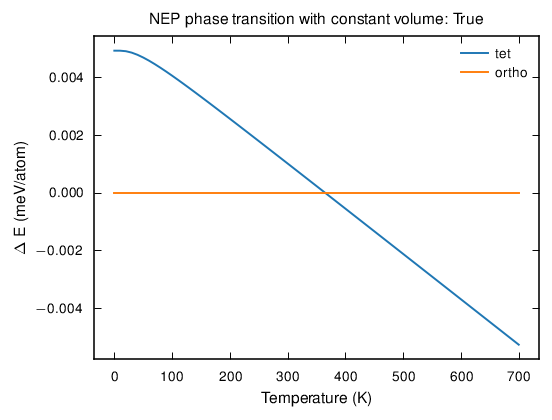

In [27]:
data_dict = dict()
sg_vals = [62, 140]
EvTokJmol = 96.4853905398362
cell = [False, True]
for c_cell in cell:
    for sg in sg_vals:
        structure = read(f'BaZrS3-spg{sg}.xyz')
        calculator = CPUNEP('nep.txt')
        structure.calc = calculator
        structure.set_constraint(FixSymmetry(structure))
        relax_structure(structure, fmax=0.000001, constant_cell=c_cell)

        E_0 = structure.get_potential_energy()/structure.get_global_number_of_atoms()
        phonon = get_force_constants(structure, calculator, [4,4,4])
        phonon.run_mesh([40, 40, 40])
        phonon.run_thermal_properties(t_step=10,
                              t_max=700,
                              t_min=0)
        phonon.write_yaml_thermal_properties(filename = f'{sg}_NEP_thermal_properties.yaml')
        print(E_0)
        # get F_vib
        with open(f'{sg}_NEP_thermal_properties.yaml') as f:
            loaded_data = yaml.safe_load(f)
        df = pd.DataFrame(loaded_data['thermal_properties'])
        temperatures = df.temperature.values
        F_vib = df['free_energy'].values / EvTokJmol / len(structure)
        F_tot = E_0 + F_vib
        data_dict[sg] = temperatures, F_tot

        phonon = get_force_constants(structure, calculator, [4,4,4])
        structure_tuple = (structure.cell, structure.get_scaled_positions(), structure.numbers)
        path = get_explicit_k_path(structure_tuple)
        phonon.run_band_structure([path['explicit_kpoints_rel']])
        band = phonon.get_band_structure_dict()
        df = DataFrame(band['frequencies'][0])
        df.index = path['explicit_kpoints_linearcoord']
        fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)

        for col in df.columns:
            ax.plot(df.index, df[col], color='blue')
        ax.set_xlim(df.index.min(), df.index.max())

        ax.set_ylabel('Frequency (THz)')
        ax2 = ax.twinx()
        ax2.set_ylabel('Frequency (cm$^{-1}$)')
        ax2.set_ylim(THzToCm * np.array(ax.get_ylim()))

        # beautify the labels on the x-axis
        labels = path['explicit_kpoints_labels']
        labels = [r'$\UG{\Gamma}$' if m == 'GAMMA' else m for m in labels]
        labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
        df_path = DataFrame(dict(labels=labels,
                         positions=path['explicit_kpoints_linearcoord']))
        df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
        ax.set_xticks(df_path.positions)
        ax.set_xticklabels(df_path.labels)
        for xp in df_path.positions:
            ax.axvline(xp, color='0.8')
        ax.set_title(f'NEP phonons from SG:{sg}')

        plt.tight_layout()


    fig, ax = plt.subplots(figsize=(4.1, 3), dpi=140)
    ax.plot(data_dict[140][0],data_dict[140][1]-data_dict[62][1], label = "tet")
    ax.plot(data_dict[140][0],data_dict[62][1]-data_dict[62][1], label = "ortho")
    ax.set_title(f'NEP phase transition with constant volume: {c_cell}')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'$\UG{\Delta}$ E (meV/atom)')
    ax.legend()

# DFT

Spacegroup    62: E_0 -0.00000 eV/atom
Spacegroup   140: E_0 0.00474 eV/atom


/var/folders/z6/b_jzphk53190vbrxr2tb1l980000gn/T/ipykernel_28762/623599545.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,-2.5, 0, 2.5, 5, 7.5, 10, 12.5])
/var/folders/z6/b_jzphk53190vbrxr2tb1l980000gn/T/ipykernel_28762/623599545.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,-2.5, 0, 2.5, 5, 7.5, 10, 12.5])
/var/folders/z6/b_jzphk53190vbrxr2tb1l980000gn/T/ipykernel_28762/623599545.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


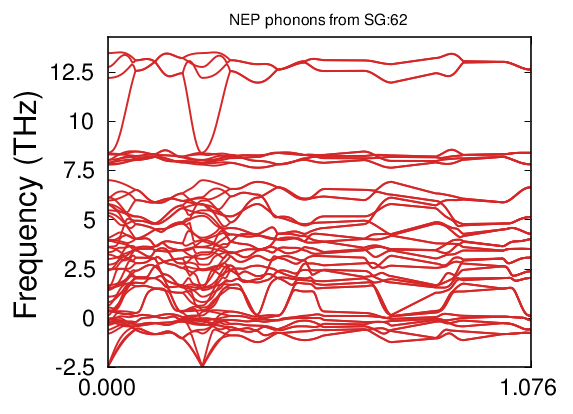

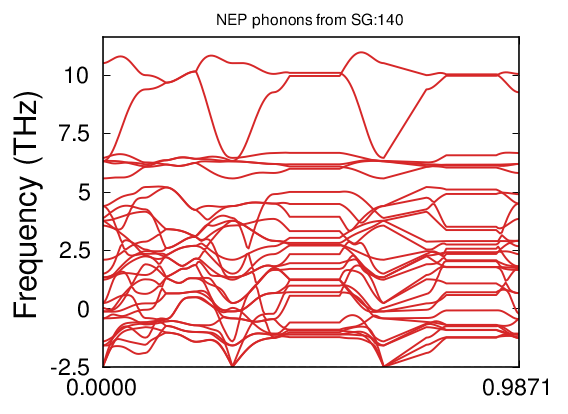

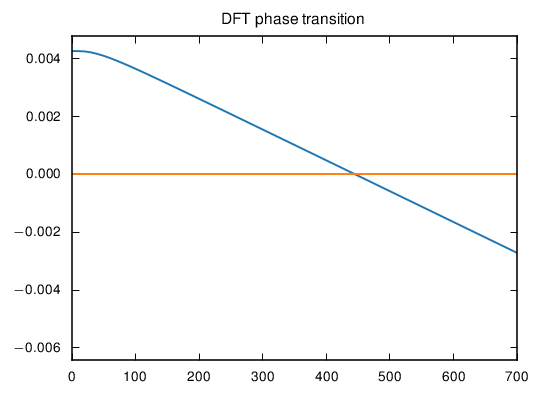

In [20]:
data_dict_DFT = dict()

E_ref = -71316.788258637  
for sg in sg_vals:
        structure = read(f'BaZrS3_tilt_{sg}/relaxation/calculation/aims.out')
        E_0 = structure.get_potential_energy() / len(structure)
        print(f'Spacegroup  {sg:4d}: E_0 {E_0 - E_ref:.5f} eV/atom')

        # get F_vib
        with open(f'BaZrS3_tilt_{sg}/phonons/phonopy/output/thermal_properties.yaml') as f:
            loaded_data = yaml.safe_load(f)
        df = pd.DataFrame(loaded_data['thermal_properties'])
        temperatures = df.temperature.values
        F_vib = df['free_energy'].values / EvTokJmol / len(structure)
        F_tot = E_0 + F_vib
        data_dict_DFT[sg] = temperatures, F_tot

        
        structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
        path = get_explicit_k_path(structure_tuple)
        phonon = phonopy.load(f'BaZrS3_tilt_{sg}/phonons/phonopy/output/phonopy.yaml')
        phonon.run_band_structure([path['explicit_kpoints_rel']])
        band = phonon.get_band_structure_dict()
        phonopy_paths, phonopy_dists, phonopy_freqs, *_ = phonon.get_band_structure()
        
        fig, ax = plt.subplots(figsize=(4.1, 3), dpi=140)
        ax.set_ylabel('Frequency (THz)', fontsize=16)
        xticks = [d[0] for d in phonopy_dists] + [phonopy_dists[-1][-1]]
        #labels = [r'$\UG{\Gamma}$' if m == 'G' else m for m in [path['explicit_kpoints_rel']]]
        ax.set_xticks(xticks)
        #ax.set_xticklabels(labels)
        ax.set_yticklabels([0,-2.5, 0, 2.5, 5, 7.5, 10, 12.5])
        ax.axhline(0, linestyle = '--', color = '0.8')
        for xp in xticks:
            ax.axvline(xp, color='0.8')

        ax.plot(np.hstack(phonopy_dists), np.vstack(phonopy_freqs), color='tab:red')
        ax.set_xlim(np.hstack(phonopy_dists).min(),np.hstack(phonopy_dists).max())
        ax.set_ylim(np.vstack(phonopy_freqs).min())
        ax.tick_params(labelsize=12)
        ax.set_title(f'NEP phonons from SG:{sg}')
        fig.tight_layout()
        


fig, ax = plt.subplots(figsize=(4.1, 3), dpi=140)
ax.plot(data_dict_DFT[140][0],data_dict_DFT[140][1]-data_dict_DFT[62][1])
ax.plot(data_dict_DFT[140][0],data_dict_DFT[62][1]-data_dict_DFT[62][1])
ax.set_xlim([0,700])
ax.set_title('DFT phase transition')
ax.legend()

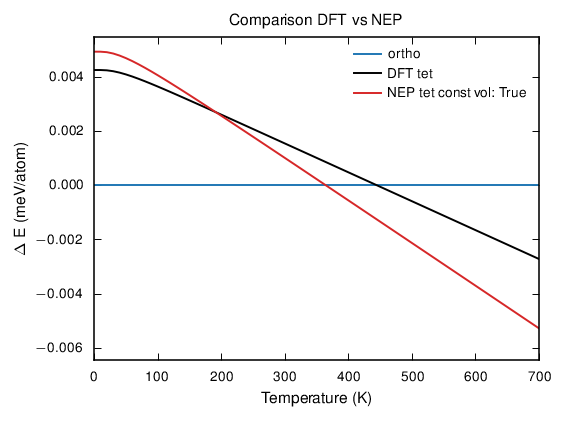

In [36]:
fig, ax = plt.subplots(figsize=(4.1, 3), dpi=140)
ax.plot(data_dict[140][0],data_dict[62][1]-data_dict[62][1], label = 'ortho', color = "tab:blue")
ax.plot(data_dict_DFT[140][0],data_dict_DFT[140][1]-data_dict_DFT[62][1], label = 'DFT tet', color= "k")
ax.plot(data_dict[140][0],data_dict[140][1]-data_dict[62][1], label = f'NEP tet const vol: {c_cell}', color= "tab:red")
ax.set_xlim([0,700])
ax.set_title('Comparison DFT vs NEP')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\UG{\Delta}$ E (meV/atom)')
ax.legend()
fig.savefig('phonopy_DFT_vs_NEP.png', bbox_inches='tight')

In [40]:
print(len(data_dict_DFT[140][1]-data_dict_DFT[62][1]))
print(len(data_dict[140][1]-data_dict[62][1]))
print(len(data_dict[62][1]-data_dict[62][1]))
print(len(data_dict[140][0]))

101
71
71
71
